In [3]:
## Data ## 
import numpy as np
import pandas as pd 
import os 

## Visualization ## 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go 

## Image ## 
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## Tensorflow ## 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

In [4]:
df = pd.read_csv('C:/Users/Nishat/OneDrive/Desktop/New folder/butterflyImages/butterflies and moths.csv')  
IMAGE_DIR = 'C:/Users/Nishat/OneDrive/Desktop/New folder/butterflyImages/'
df['filepaths'] = IMAGE_DIR + '/' + df['filepaths']
df.head()

class id                                          filepaths  labels  \
0         0  C:/Users/Nishat/OneDrive/Desktop/New folder/bu...  ADONIS   
1         0  C:/Users/Nishat/OneDrive/Desktop/New folder/bu...  ADONIS   
2         0  C:/Users/Nishat/OneDrive/Desktop/New folder/bu...  ADONIS   
3         0  C:/Users/Nishat/OneDrive/Desktop/New folder/bu...  ADONIS   
4         0  C:/Users/Nishat/OneDrive/Desktop/New folder/bu...  ADONIS   

  data set  
0    train  
1    train  
2    train  
3    train  
4    train

In [5]:
train_df = df.loc[df['data set'] == 'train']
val_df = df.loc[df['data set'] == 'valid']
test_df = df.loc[df['data set'] == 'test']

In [6]:
label_counts = df['labels'].value_counts()[:10]

fig = px.bar(x=label_counts.index, 
             y=label_counts.values,
             color=label_counts.values,
             text=label_counts.values,
             color_continuous_scale='Blues')

fig.update_layout(
    title_text='Top 10 Labels Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Label',
    ),
    yaxis=dict(
        title='Count',
    )
)

fig.update_traces(marker_line_color='black', 
                  marker_line_width=1.5, 
                  opacity=0.8)
 
fig.show()

In [9]:
def show_grid_images(image_path_list, ncols, title, augmentor=None):
    figure, axs = plt.subplots(figsize=(22,4), nrows=1, ncols=ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        if augmentor is not None:
            image = augmentor(image=image)['image']
        axs[i].imshow(image)
        axs[i].set_title(title)
    plt.show()

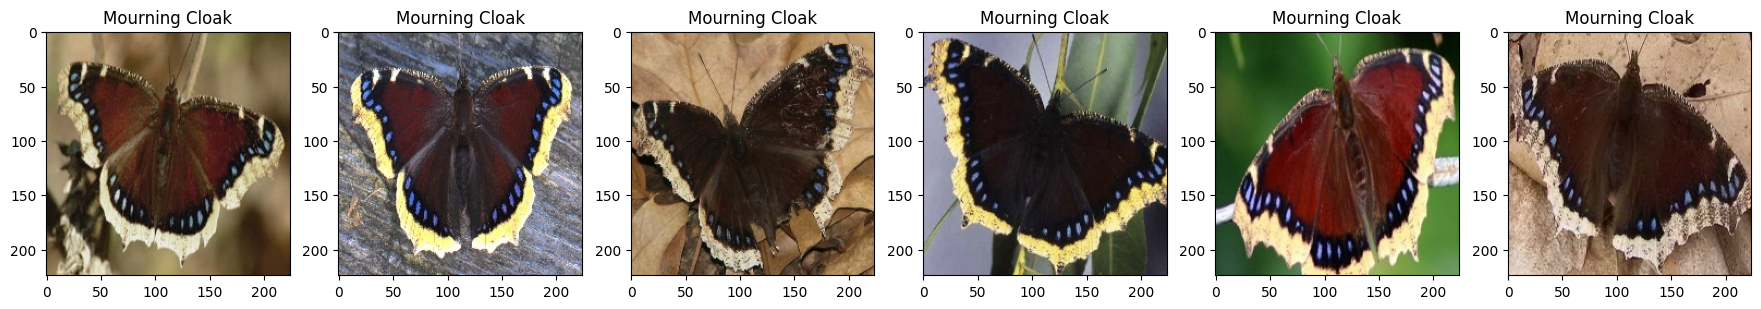

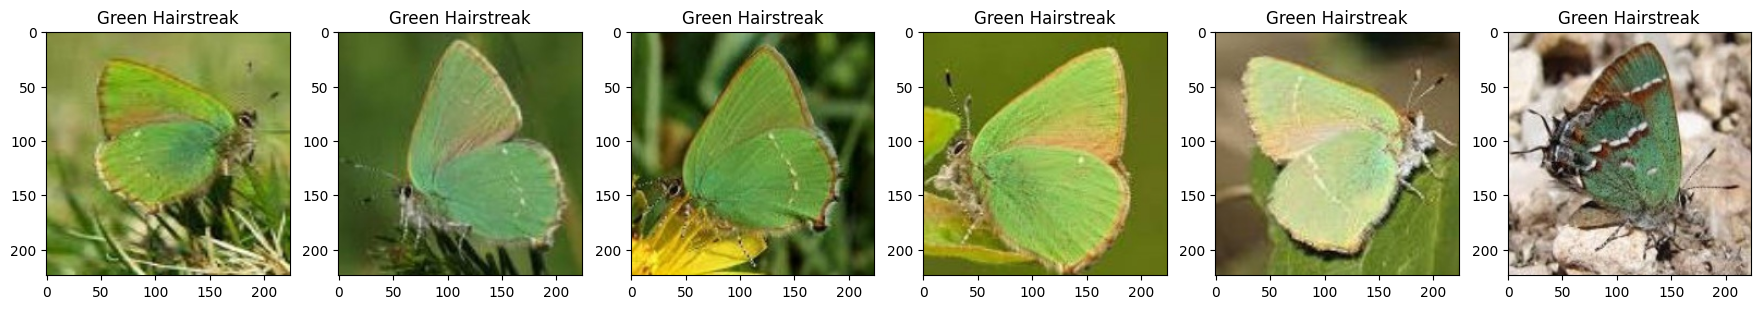

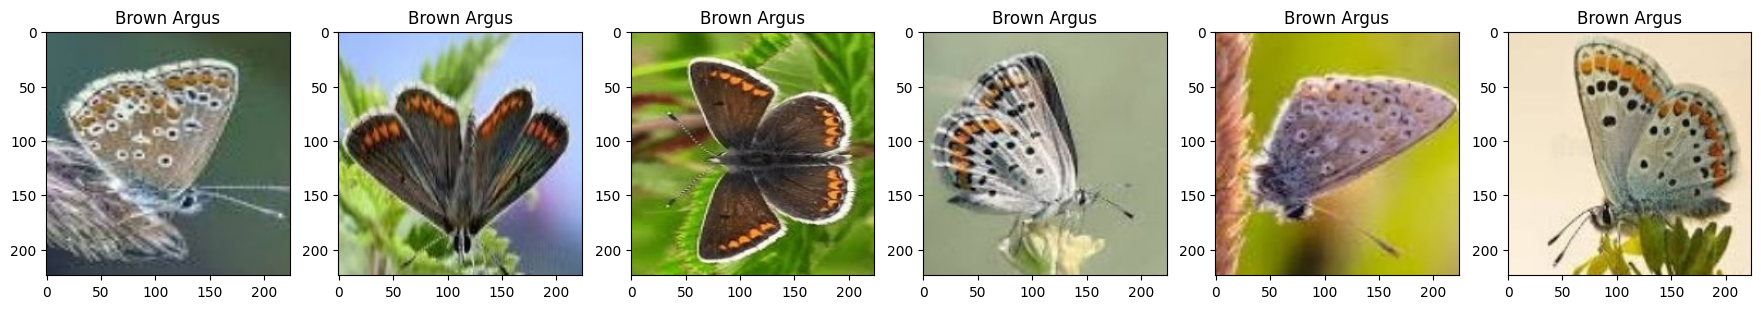

In [8]:
# Visualize top 3 most distributed dataset images
top3_labels = label_counts[:3].index.tolist()

cloak_image_list = df.loc[df['labels']==top3_labels[0]]['filepaths'].iloc[:6].tolist()
hairstreak_image_list = df.loc[df['labels']==top3_labels[1]]['filepaths'].iloc[:6].tolist() 
argus_image_list = df.loc[df['labels']==top3_labels[2]]['filepaths'].iloc[:6].tolist()

show_grid_images(cloak_image_list, ncols=6, title='Mourning Cloak')
show_grid_images(hairstreak_image_list, ncols=6, title='Green Hairstreak')
show_grid_images(argus_image_list, ncols=6, title='Brown Argus')

In [11]:
# only train data needs to be augmented 
train_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1/255.)
val_gen = ImageDataGenerator(rescale=1/255.)

train_dir = 'C:/Users/Nishat/OneDrive/Desktop/New folder/butterflyImages/train'
val_dir = 'C:/Users/Nishat/OneDrive/Desktop/New folder/butterflyImages/valid'

BATCH_SIZE = 64
SEED = 56
IMAGE_SIZE = (244, 244)

train_flow_gen = train_gen.flow_from_directory(directory=train_dir,
                                              class_mode='sparse',
                                              batch_size=BATCH_SIZE,
                                              target_size=IMAGE_SIZE,
                                              seed=SEED)

val_flow_gen = val_gen.flow_from_directory(directory=val_dir,
                                            class_mode='sparse',
                                            batch_size=BATCH_SIZE,
                                            target_size=IMAGE_SIZE,
                                            seed=SEED)

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [12]:
def create_model(model_name, verbose=False):
    
    input_tensor = Input(shape=(224, 224, 3))
    
    if model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    output = Dense(100, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [16]:
xception_model = create_model(model_name='xception', verbose=False)
xception_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=0)
early_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)

In [1]:
xception_model.fit(train_flow_gen, epochs=5,
         steps_per_epoch=int(np.ceil(train_df.shape[0]/BATCH_SIZE)),
         validation_data=val_flow_gen,
         validation_steps=int(np.ceil(val_df.shape[0]/BATCH_SIZE)),
         callbacks=[rlr_cb, early_cb])

NameError: name 'xception_model' is not defined

In [ ]:
test_dir = 'C:/Users/Nishat/OneDrive/Desktop/New folder/butterflyImages/test'
test_gen = ImageDataGenerator(rescale=1/255.)
test_flow_gen = test_gen.flow_from_directory(directory=test_dir,
                                             class_mode='sparse',
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SIZE,
                                             seed=SEED)

In [ ]:
print('Xception Test Data Accuracy: {0}'.format(xception_model.evaluate(test_flow_gen)[1:][0]))

In [ ]:
resnet_model = create_model(model_name='resnet50', verbose=False)
resnet_model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=0)
early_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)

In [ ]:
resnet_model.fit(train_flow_gen, epochs=15,
         steps_per_epoch=int(np.ceil(train_df.shape[0]/BATCH_SIZE)),
         validation_data=val_flow_gen,
         validation_steps=int(np.ceil(val_df.shape[0]/BATCH_SIZE)),
         callbacks=[rlr_cb, early_cb])

In [ ]:
print('ResNet Test Data Accuracy: {0}'.format(resnet_model.evaluate(test_flow_gen)[1:][0]))

In [ ]:
models = ['Xception', 'ResNet50']
validation_accuracy = [0.9938, 0.9674]
test_accuracy = [0.9720, 0.9620]

fig = go.Figure(data=[
    go.Bar(name='Validation Dataset Accuracy',
          x=models,
          y=validation_accuracy,
          text=validation_accuracy,
          marker_color='#219ebc'),
    go.Bar(name='Validation Dataset Accuracy',
          x=models,
          y=test_accuracy,
          text=test_accuracy,
          marker_color='#ffb703'),
])

fig.update_layout(
    title_text='Model Comparison',
    barmode='group',
    xaxis=dict(
        title='Model',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Accuracy',
        titlefont_size=16
    ),
    template='plotly_white'
)

fig.update_traces(marker_line_color='black', 
                  marker_line_width=2, 
                  opacity=0.8)

fig.show()